## Model Strategy, Evaluation Metrics, and Selection Criteria

### Objective
To identify the most accurate and robust model for traffic flow forecasting using real-world traffic sensor data. The best model will later feed into EV charging coordination simulations for improving power system resilience.



## Modeling Strategy

We will compare **9 models** across 4 categories:

| Category                    | Models |
|----------------------------|--------|
| **Baseline Models**        | Linear Regression, LSTM-only |
| **Published Hybrid Model** | CNN-GRU-LSTM (from literature) |
| **Graph-based Models**     | DCRNN-only, STGCN-only, GraphWaveNet-only |
| **Proposed Hybrid Models** | DCRNN-GRU-LSTM, STGCN-GRU-LSTM, GraphWaveNet-GRU-LSTM |


## Model Rationales

**1. Baseline Models**
- *Linear Regression*: Simple, interpretable benchmark.
- *LSTM-only*: Captures temporal patterns without spatial structure.

**2. CNN-GRU-LSTM (Literature Benchmark)**
- Combines CNN (spatial features) + GRU + LSTM (short and long-term temporal dependencies).
- Reproduced from a recent paper for benchmarking.

**3. Graph-based Models**
- *DCRNN*: Diffusion convolution (directed graphs) + RNNs.
- *STGCN*: Chebyshev graph convolution + temporal convolution.
- *GraphWaveNet*: Adaptive graph learning + dilated causal convolutions.

**4. Proposed Hybrid Models**
- Combines graph-based spatial modules with GRU and LSTM layers to leverage deep spatial-temporal dependencies.



## Forecasting Horizon

We forecast traffic **72 hours ahead (3 days)** using multi-output models. This helps evaluate short- and medium-term predictive accuracy.

- Models will be trained to predict:
  - The next **12, 24 hours**,
  - And the next **48, 72 hours** ahead.


## Evaluation Metrics

We will use **three key metrics** for model comparison:

- **MAPE (Mean Absolute Percentage Error)**: 
  - Interpretable percentage error.
- **RMSE (Root Mean Squared Error)**: 
  - Penalizes larger errors more heavily.
- **MAE (Mean Absolute Error)**: 
  - Stable average error measure.

All models will be evaluated on the same test set using these metrics at both 24h and 72h forecasting horizons.



## Model Selection Criteria

Final model will be selected based on:

1. **Lowest RMSE, MAE, and MAPE** on test data.
2. **Spatial consistency**: Station-level errors should not vary drastically.
3. **Generalization ability**: Minimal overfitting (close validation and test performance).
4. **Efficiency** *(secondary)*: Preference for simpler or faster models if performance is tied.


## Input Features (Used Across All Models)

To ensure a fair comparison, all 9 models will use the same feature set:

- **Temporal Features**: hour, day, month, weekday, holiday flags.
- **Lag Features**: Flow_lag_1 to Flow_lag_72.
- **Sliding Window Stats**: rolling mean, min, max, std.
- **Cyclical Features**: sine/cosine of time variables.
- **Graph Features**:
  - *DCRNN*: fixed adjacency matrix from CV clustering.
  - *STGCN*: Chebyshev-based graph structure.
  - *GraphWaveNet*: learns the adjacency dynamically.


## Summary

- Compare 9 models (baseline, benchmark, graph-based, hybrid).
- Forecast 24h and 72h ahead.
- Use MAPE, RMSE, MAE as evaluation metrics.
- Select best model for downstream EV charging coordination.


## Loading Libraries

In [1]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import lightgbm as lgb
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv")

In [5]:
df. head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,10/01/2024 00:00:00,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/01/2024 00:00:00,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/01/2024 00:00:00,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/01/2024 00:00:00,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/01/2024 00:00:00,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(4114680, 42)

## Basic Exploration 

In [7]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [8]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,64.1,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,NaN,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,NaN,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,NaN,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,NaN,92,303,OR


In [9]:
df.isna().sum()

Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              303776
Avg Speed              1582594
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64

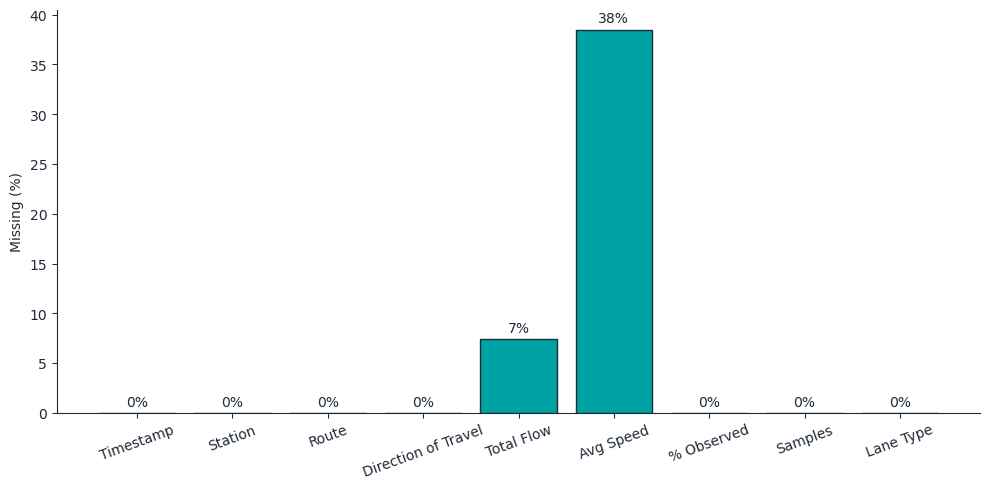

In [10]:
# missingness_plot.py

OUTPUT = "missingness_data_cleaning.png"
# ==============================


# Compute % missing per column
missing_pct = (df.isna().mean() * 100).round(1)

# --- Colors to match slides ---
elec_teal = "#00A3A3"
deep_navy = "#1F2937"

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(missing_pct.index, missing_pct.values, color=elec_teal, edgecolor=deep_navy)

# Axes styling
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(deep_navy)
ax.spines["bottom"].set_color(deep_navy)

ax.set_ylabel("Missing (%)", color=deep_navy)
ax.set_ylim(0, max(10, missing_pct.max() + 2))  # room for labels
ax.tick_params(axis="x", labelrotation=20, colors=deep_navy)
ax.tick_params(axis="y", colors=deep_navy)

# Annotate each bar
for x, y in zip(missing_pct.index, missing_pct.values):
    ax.text(x, y + 0.4, f"{y:.0f}%", ha="center", va="bottom", fontsize=10, color=deep_navy)

plt.tight_layout()
plt.savefig(OUTPUT, dpi=300, bbox_inches="tight")

In [11]:
df.drop(columns=["Avg Speed"], inplace=True)

In [12]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [13]:
df.isna().sum()

Timestamp                   0
Station                     0
Route                       0
Direction of Travel         0
Total Flow             303776
% Observed                  0
Samples                     0
Lane Type                   0
dtype: int64

In [14]:
df = df[df['Total Flow'].notna()]

In [15]:
df.isna().sum()

Timestamp              0
Station                0
Route                  0
Direction of Travel    0
Total Flow             0
% Observed             0
Samples                0
Lane Type              0
dtype: int64

In [16]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [17]:
df.dtypes

Timestamp               object
Station                  int64
Route                    int64
Direction of Travel     object
Total Flow             float64
% Observed               int64
Samples                  int64
Lane Type               object
dtype: object

In [18]:
df.duplicated().sum()

0

In [19]:
df.reset_index().duplicated(subset=['Timestamp', 'Station']).sum()

0

In [20]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [21]:
# Convert Station to categorical type
df['Station'] = df['Station'].astype('category')

In [22]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
Timestamp,,,,,,,
2024-10-01,308512,50,W,497.0,0,197,ML
2024-10-01,311831,5,S,27.0,92,101,OR
2024-10-01,311832,5,S,78.0,92,101,FR
2024-10-01,311844,5,N,43.0,92,202,OR
2024-10-01,311847,5,N,73.0,92,303,OR


## Feature Engineering

Feature engineering is a critical step in building accurate and generalizable forecasting models. In this study, we developed a systematic approach to derive a rich, interpretable, and computationally efficient feature set for training all nine models evaluated in our framework.

Our final feature set was not chosen arbitrarily; it emerged from a structured process combining **exploratory data analysis (EDA)**, **domain intuition**, and **model-based importance evaluation** using a Light Gradient Boosting Machine (LightGBM) model.


### Initial Feature Design Strategy

We began by constructing a broad feature space categorized into four major groups:

#### A. Flow Dynamics Features
These features capture recent trends in traffic flow by applying rolling statistics (mean, std, min, max) across windows ranging from 3 to 72 hours. These are critical for helping models understand:
- Short-term volatility (e.g., 3h windows for rush hour spikes)
- Medium-range patterns (e.g., 24h, 48h) that reflect diurnal and weekday cycles
- Longer-term load profiles (e.g., 72h flow trends)

We also included the **Coefficient of Variation (CV)**, a normalized measure of variability (`std / mean`), to account for flow unpredictability in different time scales.

#### B. Temporal Lag Features
Lagged features allow models to learn from recent past values, a hallmark of autoregressive forecasting. We selected lags at strategic intervals:
- Short memory (lags 1–3)
- Weekly periodic memory (lags 7–8)
- Medium-range dependencies (lags 15 and 18)


#### C. Time-Based Encodings
Time-of-day and day-of-week effects are essential in traffic forecasting. Rather than using raw integers, we employed **cyclical encodings** using sine and cosine transformations to preserve temporal continuity. This helped models, especially neural networks, avoid false discontinuities in time-based features.

#### D. Data Quality Features
We included `Samples` and `% Observed` to account for sensor reliability. These quality indicators allow the model to weight predictions based on the confidence level of the data collected at each hour.


###  Model-Based Feature Selection with LightGBM

To refine and validate our engineered feature set, we trained a **LightGBM regression model** on the full feature space. LightGBM, a gradient boosting framework, is well-suited for this task due to its fast training speed, high predictive accuracy, and native support for evaluating feature importance.

Given that our dataset spans three full months of **hourly traffic data**, it contains a **large volume of observations** across multiple stations and variables. Training models on such a high-dimensional dataset without carefully selecting features could lead to overfitting, increased computational cost, and reduced generalizability.

Therefore, we used LightGBM to identify and retain the most informative predictors. By analyzing gain-based feature importance scores, we reduced the initial feature set to high-impact subset that preserves predictive power while improving model efficiency. This final feature space is used consistently across all nine forecasting models evaluated in this study.

We used **gain-based importance scores** to identify which features contributed most to model performance. The top-ranked features included:

- `Flow_mean_3`, `Flow_max_3`, `Flow_mean_72`, `Flow_std_72`
- `TotalFlow_lag_1`, `TotalFlow_lag_2`
- `Hour_cos`, `Samples`, and `% Observed`

Based on this diagnostic model, we **removed low-contributing and redundant features** (e.g., highly correlated lags or rolling stats with minimal gain) and retained those that consistently ranked among the top 30 most important variables.


###  Finalized Feature Set for All Models

The final reduced feature set consists of the following:

#### Flow Dynamics Features (12)
- `Flow_mean_3`, `Flow_std_3`, `Flow_max_3`, `Flow_min_3`  
- `Flow_mean_24`, `Flow_mean_48`, `Flow_mean_72`  
- `Flow_std_48`, `Flow_std_72`, `Flow_roll_std_6h`, `Flow_roll_max_6h`, `Flow_CV_48`

####  Temporal Lag Features (7)
- `TotalFlow_lag_1`, `lag_2`, `lag_3`, `lag_7`, `lag_8`, `lag_15`, `lag_18`

####  Time-Based Features (4)
- `Hour`, `Hour_cos`, `Hour_sin`, `Weekday_cos`

####  Data Quality Features (2)
- `Samples`, `% Observed`

####  Categorical Features
- Label-encoded: `Station`, `Route`, `Lane Type`  
- One-hot encoded: `Direction of Travel`, `IsHoliday`  
- Dummy variables dynamically captured and appended

>  **Total feature space**: This reduced set balances temporal depth, spatial generalization, and model interpretability. It is optimized for use across classical models (e.g., linear regression), deep learning architectures (e.g., LSTM), and graph-based models (e.g., DCRNN, STGCN).

The feature selection process—guided by LightGBM importance, domain knowledge, and statistical properties—provides a strong foundation for reliable, scalable forecasting and supports the broader goal of **coordinated EV charging simulations** in the next phase of this research.

In [23]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

In [24]:
for lag in range(1, 73):  # Lags 1 to 72
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

# Drop the rows that now have NaNs in these lag features (first 72 rows)
df.dropna(inplace=True)

In [25]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [26]:
df['Flow_roll_mean_6h'] = df['Total Flow'].rolling(window=6).mean()
df['Flow_roll_std_6h'] = df['Total Flow'].rolling(window=6).std()
df['Flow_roll_max_6h'] = df['Total Flow'].rolling(window=6).max()
df['Flow_roll_min_6h'] = df['Total Flow'].rolling(window=6).min()

In [27]:
for window in [3, 12, 24, 48, 72]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()

In [28]:
df.dropna(inplace=True)

In [29]:
custom_holidays = [
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

In [30]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_max_24,Flow_mean_48,Flow_std_48,Flow_min_48,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,IsHoliday
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,313344,50,W,190.0,92,202,ML,0,1,1,...,1068.0,395.833333,570.838627,3.0,3419.0,435.736111,522.596712,3.0,3419.0,0
2024-10-01,313349,50,W,190.0,92,202,ML,0,1,1,...,1068.0,399.458333,568.924516,3.0,3419.0,437.486111,521.544267,3.0,3419.0,0
2024-10-01,313368,80,W,787.0,100,719,ML,0,1,1,...,1068.0,404.375000,571.276906,3.0,3419.0,440.069444,522.824677,3.0,3419.0,0
2024-10-01,313386,80,W,1050.0,92,404,ML,0,1,1,...,1068.0,426.000000,575.736716,3.0,3419.0,443.555556,526.078366,3.0,3419.0,0
2024-10-01,313393,80,E,1064.0,92,505,ML,0,1,1,...,1068.0,376.937500,383.507686,3.0,1525.0,457.500000,529.066225,3.0,3419.0,0


In [31]:
for window in [12, 24, 48, 72]:
    df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

In [32]:
df.dropna(inplace=True)

In [33]:
# Group by station and calculate mean and std of Total Flow
station_stats = df.groupby('Station')['Total Flow'].agg(['mean', 'std'])
station_stats['CV'] = station_stats['std'] / station_stats['mean']
station_stats.dropna(inplace=True)  

In [34]:
pd.set_option('display.max_columns', None)
df.head()


,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,IsWeekend,TotalFlow_lag_1,TotalFlow_lag_2,TotalFlow_lag_3,TotalFlow_lag_4,TotalFlow_lag_5,TotalFlow_lag_6,TotalFlow_lag_7,TotalFlow_lag_8,TotalFlow_lag_9,TotalFlow_lag_10,TotalFlow_lag_11,TotalFlow_lag_12,TotalFlow_lag_13,TotalFlow_lag_14,TotalFlow_lag_15,TotalFlow_lag_16,TotalFlow_lag_17,TotalFlow_lag_18,TotalFlow_lag_19,TotalFlow_lag_20,TotalFlow_lag_21,TotalFlow_lag_22,TotalFlow_lag_23,TotalFlow_lag_24,TotalFlow_lag_25,TotalFlow_lag_26,TotalFlow_lag_27,TotalFlow_lag_28,TotalFlow_lag_29,TotalFlow_lag_30,TotalFlow_lag_31,TotalFlow_lag_32,TotalFlow_lag_33,TotalFlow_lag_34,TotalFlow_lag_35,TotalFlow_lag_36,TotalFlow_lag_37,TotalFlow_lag_38,TotalFlow_lag_39,TotalFlow_lag_40,TotalFlow_lag_41,TotalFlow_lag_42,TotalFlow_lag_43,TotalFlow_lag_44,TotalFlow_lag_45,TotalFlow_lag_46,TotalFlow_lag_47,TotalFlow_lag_48,TotalFlow_lag_49,TotalFlow_lag_50,TotalFlow_lag_51,TotalFlow_lag_52,TotalFlow_lag_53,TotalFlow_lag_54,TotalFlow_lag_55,TotalFlow_lag_56,TotalFlow_lag_57,TotalFlow_lag_58,TotalFlow_lag_59,TotalFlow_lag_60,TotalFlow_lag_61,TotalFlow_lag_62,TotalFlow_lag_63,TotalFlow_lag_64,TotalFlow_lag_65,TotalFlow_lag_66,TotalFlow_lag_67,TotalFlow_lag_68,TotalFlow_lag_69,TotalFlow_lag_70,TotalFlow_lag_71,TotalFlow_lag_72,Hour_sin,Hour_cos,Weekday_sin,Weekday_cos,Flow_roll_mean_6h,Flow_roll_std_6h,Flow_roll_max_6h,Flow_roll_min_6h,Flow_mean_3,Flow_std_3,Flow_min_3,Flow_max_3,Flow_mean_12,Flow_std_12,Flow_min_12,Flow_max_12,Flow_mean_24,Flow_std_24,Flow_min_24,Flow_max_24,Flow_mean_48,Flow_std_48,Flow_min_48,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,IsHoliday,Flow_CV_12,Flow_CV_24,Flow_CV_48,Flow_CV_72
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-01,313344,50,W,190.0,92,202,ML,0,1,1,0,218.0,859.0,656.0,709.0,699.0,208.0,575.0,502.0,1068.0,46.0,582.0,52.0,633.0,75.0,43.0,590.0,75.0,5.0,212.0,39.0,202.0,3.0,263.0,35.0,51.0,317.0,26.0,379.0,53.0,39.0,343.0,106.0,68.0,350.0,40.0,401.0,1525.0,77.0,531.0,13.0,777.0,1295.0,72.0,3419.0,12.0,551.0,16.0,765.0,731.0,864.0,121.0,1097.0,1043.0,102.0,635.0,13.0,840.0,104.0,16.0,982.0,903.0,819.0,44.0,652.0,43.0,1016.0,59.0,60.0,799.0,601.0,64.0,582.0,0.0,1.0,0.781831,0.62349,555.166667,280.664509,859.0,190.0,422.333333,378.423484,190.0,859.0,526.000000,306.055253,46.0,1068.0,354.333333,313.347517,3.0,1068.0,395.833333,570.838627,3.0,3419.0,435.736111,522.596712,3.0,3419.0,0,0.581854,0.884330,1.442119,1.199342
2024-10-01,313349,50,W,190.0,92,202,ML,0,1,1,0,190.0,218.0,859.0,656.0,709.0,699.0,208.0,575.0,502.0,1068.0,46.0,582.0,52.0,633.0,75.0,43.0,590.0,75.0,5.0,212.0,39.0,202.0,3.0,263.0,35.0,51.0,317.0,26.0,379.0,53.0,39.0,343.0,106.0,68.0,350.0,40.0,401.0,1525.0,77.0,531.0,13.0,777.0,1295.0,72.0,3419.0,12.0,551.0,16.0,765.0,731.0,864.0,121.0,1097.0,1043.0,102.0,635.0,13.0,840.0,104.0,16.0,982.0,903.0,819.0,44.0,652.0,43.0,1016.0,59.0,60.0,799.0,601.0,64.0,0.0,1.0,0.781831,0.62349,470.333333,304.414630,859.0,190.0,199.333333,16.165808,190.0,218.0,493.333333,320.131034,46.0,1068.0,351.291667,314.624342,3.0,1068.0,399.458333,568.924516,3.0,3419.0,437.486111,521.544267,3.0,3419.0,0,0.648914,0.895621,1.424240,1.192139
2024-10-01,313368,80,W,787.0,100,719,ML,0,1,1,0,190.0,190.0,218.0,859.0,656.0,709.0,699.0,208.0,575.0,502.0,1068.0,46.0,582.0,52.0,633.0,75.0,43.0,590.0,75.0,5.0,212.0,39.0,202.0,3.0,263.0,35.0,51.0,317.0,26.0,379.0,53.0,39.0,343.0,106.0,68.0,350.0,40.0,401.0,1525.0,77.0,531.0,13.0,777.0,1295.0,72.0,3419.0,12.0,551.0,16.0,765.0,731.0,864.0,121.0,1097.0,1043.0,102.0,635.0,13.0,840.0,104.0,16.0,982.0,903.0,819.0,44.0,652.0,43.0,1016.0,59.0,60.0,799.0,601.0,0.0,1.0,0.781831,0.62349,483.333333,318.007337,859.0,190.0,389.000000,344.678111,190.0,787.0,555.083333,296.601802,190.0,1068.0,383.958333,317.576349,5.0,1068.0,404.375000,571.276906,3.0,3419.0,440.069444,522.824677,3.0,3419.0,0,0.534337,0.827111,1.41

Saved acf_lags.png  |  Station 3900024  |  Flow column: Total Flow


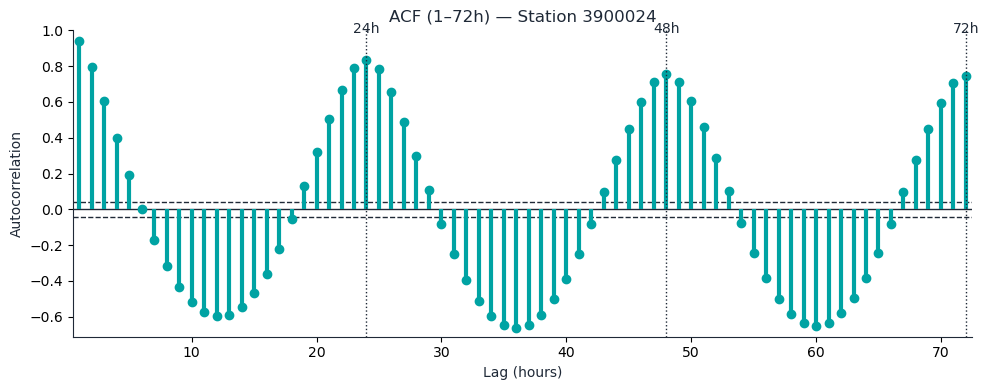

In [107]:
# acf_lags_from_df.py
# Creates acf_lags.png using your current `df` (handles spaces, casing, index-levels)

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

MAX_LAG = 72
FORCE_STATION_ID = None        # set e.g. 313344 to force a station
OUTPUT = "acf_lags.png"

# ---------- helpers ----------
def norm(s):
    """lowercase, strip, remove non-alphanumerics"""
    return re.sub(r"[^a-z0-9]", "", str(s).strip().lower())

def find_col(df, targets, contains=None):
    """return exact match by normalized name, else first col containing substring(s)"""
    cols = list(df.columns)
    nmap = {c: norm(c) for c in cols}
    targets_n = {norm(t) for t in targets}
    # exact (normalized) match
    for c, nc in nmap.items():
        if nc in targets_n:
            return c
    # contains any substring(s)
    if contains:
        tokens = [norm(t) for t in (contains if isinstance(contains, (list, tuple)) else [contains])]
        for c in cols:
            nc = nmap[c]
            if any(tok in nc for tok in tokens):
                return c
    return None

def get_ts_index(df):
    """ensure DatetimeIndex; if Timestamp-like col exists, set it"""
    if isinstance(df.index, pd.DatetimeIndex):
        return df.sort_index()
    ts_col = find_col(df, ["Timestamp","DateTime","Time","Date"], contains="time")
    if ts_col is None:
        raise ValueError("Couldn't find a timestamp column or DatetimeIndex.")
    out = df.copy()
    out[ts_col] = pd.to_datetime(out[ts_col], errors="coerce")
    out = out.set_index(ts_col).sort_index()
    return out

def ensure_column_from_index(df, name_hint):
    """if 'Station' is an index level, bring it out as a column"""
    if df.index.names and any(name_hint == norm(n) for n in df.index.names if n is not None):
        # bring that index level out as column
        for lvl, nm in enumerate(df.index.names):
            if nm is not None and norm(nm) == name_hint:
                return df.reset_index(level=nm)
    return df

# ---------- 1) Prepare frame ----------
work = get_ts_index(df)                         # DatetimeIndex guaranteed
work = ensure_column_from_index(work, "station")

# ---------- 2) Locate columns robustly ----------
station_col = find_col(work, ["Station","Station ID","station_id"], contains="station")
flow_col    = find_col(work, ["Total Flow","total_flow"], contains=["total","flow"])  # picks 'total flow' first

if station_col is None:
    raise KeyError("Could not locate a 'Station' column or index level in df.")
if flow_col is None:
    raise KeyError("Could not locate a 'Total Flow' (or flow) column in df.")

# ---------- 3) Choose station & build hourly series ----------
if FORCE_STATION_ID is None:
    sid = (work.groupby(station_col)[flow_col].count()
                 .sort_values(ascending=False)
                 .index[0])
else:
    sid = FORCE_STATION_ID

s = (work[work[station_col] == sid][flow_col]
       .dropna()
       .asfreq("H")                 # regularize
       .interpolate("time")         # tiny gaps for ACF stability (viz only)
     )

if len(s) < MAX_LAG + 5:
    raise RuntimeError(f"Series too short for {MAX_LAG}h ACF (len={len(s)}). Try another station or smaller MAX_LAG.")

# ---------- 4) Compute ACF ----------
acf = [s.autocorr(l) for l in range(1, MAX_LAG+1)]
n = len(s)
conf = 1.96/np.sqrt(n)

# ---------- 5) Plot ----------
elec_teal, deep_navy = "#00A3A3", "#1F2937"
x = np.arange(1, MAX_LAG+1)

fig, ax = plt.subplots(figsize=(10,4))
ax.axhline(0, color=deep_navy, lw=1)
ax.axhline(+conf, color=deep_navy, lw=1, ls="--")
ax.axhline(-conf, color=deep_navy, lw=1, ls="--")
ax.vlines(x, 0, acf, colors=elec_teal, lw=3)
ax.plot(x, acf, "o", color=elec_teal)

for k in (24, 48, 72):
    if k <= MAX_LAG:
        ax.axvline(k, color=deep_navy, ls=":", lw=1)
        ax.text(k, min(1, max(acf)+0.03), f"{k}h", ha="center", va="bottom", color=deep_navy)

ax.set_xlim(0.5, MAX_LAG+0.5)
ax.set_ylim(min(-0.2, min(acf)-0.05), 1.0)
ax.set_xlabel("Lag (hours)", color=deep_navy)
ax.set_ylabel("Autocorrelation", color=deep_navy)
ax.set_title(f"ACF (1–{MAX_LAG}h) — Station {sid}", color=deep_navy)
for s_ in ("top","right"): ax.spines[s_].set_visible(False)
ax.spines["left"].set_color(deep_navy); ax.spines["bottom"].set_color(deep_navy)
fig.tight_layout()
fig.savefig(OUTPUT, dpi=300, bbox_inches="tight")
print(f"Saved {OUTPUT}  |  Station {sid}  |  Flow column: {flow_col}")


Saved acf_lags_avg.png (stations used: 30)
Saved acf_keylags_box.png


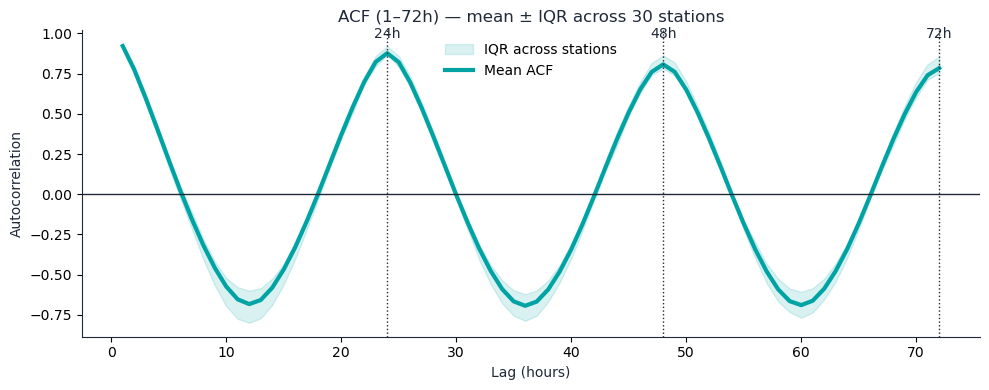

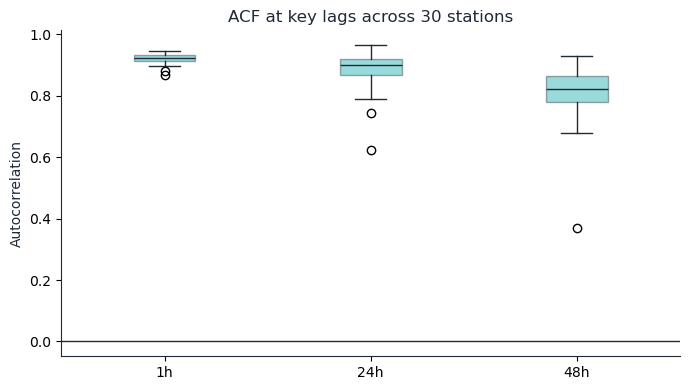

In [105]:
# acf_robustness_from_df.py
# Build aggregated ACF evidence from YOUR df.
# Outputs: acf_lags_avg.png  and  acf_keylags_box.png
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

MAX_LAG = 72
TOP_K = 30            # how many most-complete stations to aggregate
KEY_LAGS = [1, 24, 48]
OUT1 = "acf_lags_avg.png"
OUT2 = "acf_keylags_box.png"

# ---------- helpers ----------
def norm(s): return re.sub(r"[^a-z0-9]", "", str(s).strip().lower())
def find_col(df, targets, contains=None):
    targets_n = {norm(t) for t in targets}
    for c in df.columns:
        if norm(c) in targets_n: return c
    if contains:
        toks = [norm(t) for t in (contains if isinstance(contains,(list,tuple)) else [contains])]
        for c in df.columns:
            nc = norm(c)
            if any(t in nc for t in toks): return c
    return None
def get_ts_index(df):
    if isinstance(df.index, pd.DatetimeIndex): return df.sort_index()
    ts_col = find_col(df, ["Timestamp","DateTime","Time","Date"], contains="time")
    if ts_col is None: raise ValueError("Couldn't find a timestamp column or DatetimeIndex.")
    out = df.copy(); out[ts_col] = pd.to_datetime(out[ts_col], errors="coerce")
    return out.set_index(ts_col).sort_index()
def ensure_station_col(df):
    # If station is an index level, bring it out
    idx_names = [n for n in (df.index.names or []) if n is not None]
    for nm in idx_names:
        if norm(nm) in {norm("Station"), norm("Station ID"), norm("station_id")}:
            return df.reset_index(level=nm)
    return df

# ---------- prep ----------
work = get_ts_index(df)
work = ensure_station_col(work)

station_col = find_col(work, ["Station","Station ID","station_id"], contains="station")
flow_col    = find_col(work, ["Total Flow","total_flow"], contains=["total","flow"])
if station_col is None: raise KeyError("Couldn't locate a Station column/index.")
if flow_col is None:    raise KeyError("Couldn't locate a Total Flow column.")

# pick top-K stations by availability
top = (work.groupby(station_col)[flow_col].count()
             .sort_values(ascending=False)
             .head(TOP_K).index)

acfs = []
acf_at_key = {k: [] for k in KEY_LAGS}
n_used = 0
for sid in top:
    s = (work[work[station_col]==sid][flow_col]
           .dropna()
           .asfreq("H")
           .interpolate("time"))
    if len(s) < MAX_LAG + 5:  # skip short series
        continue
    n_used += 1
    this_acf = [s.autocorr(l) for l in range(1, MAX_LAG+1)]
    acfs.append(this_acf)
    for k in KEY_LAGS:
        if k <= MAX_LAG:
            acf_at_key[k].append(this_acf[k-1])

acfs = np.array(acfs)
if acfs.size == 0:
    raise RuntimeError("No stations had sufficient data for ACF. Lower TOP_K or MAX_LAG.")

mean_acf = np.nanmean(acfs, axis=0)
lo = np.nanpercentile(acfs, 25, axis=0)
hi = np.nanpercentile(acfs, 75, axis=0)
x = np.arange(1, MAX_LAG+1)

elec_teal, deep_navy = "#00A3A3", "#1F2937"

# --- Figure 1: mean ± IQR ---
plt.figure(figsize=(10,4))
plt.fill_between(x, lo, hi, color=elec_teal, alpha=0.15, label="IQR across stations")
plt.plot(x, mean_acf, color=elec_teal, lw=3, label="Mean ACF")
for k in (24, 48, 72):
    if k <= MAX_LAG:
        plt.axvline(k, color=deep_navy, ls=":", lw=1)
        plt.text(k, max(mean_acf)+0.03, f"{k}h", ha="center", va="bottom", color=deep_navy)
plt.axhline(0, color=deep_navy, lw=1)
plt.xlabel("Lag (hours)", color=deep_navy); plt.ylabel("Autocorrelation", color=deep_navy)
plt.title(f"ACF (1–{MAX_LAG}h) — mean ± IQR across {n_used} stations", color=deep_navy)
for s in ("top","right"): plt.gca().spines[s].set_visible(False)
plt.gca().spines["left"].set_color(deep_navy); plt.gca().spines["bottom"].set_color(deep_navy)
plt.legend(frameon=False)
plt.tight_layout(); plt.savefig(OUT1, dpi=300, bbox_inches="tight")
print(f"Saved {OUT1} (stations used: {n_used})")

# --- Figure 2: boxplot at key lags ---
data = [acf_at_key[k] for k in KEY_LAGS]
plt.figure(figsize=(7,4))
bp = plt.boxplot(data, labels=[f"{k}h" for k in KEY_LAGS], patch_artist=True)
for patch in bp['boxes']:
    patch.set(facecolor=elec_teal, edgecolor=deep_navy, alpha=0.4)
for el in ['medians','whiskers','caps']:
    for item in bp[el]:
        item.set(color=deep_navy)
plt.axhline(0, color=deep_navy, lw=1)
plt.ylabel("Autocorrelation", color=deep_navy)
plt.title(f"ACF at key lags across {n_used} stations", color=deep_navy)
for s in ("top","right"): plt.gca().spines[s].set_visible(False)
plt.gca().spines["left"].set_color(deep_navy); plt.gca().spines["bottom"].set_color(deep_navy)
plt.tight_layout(); plt.savefig(OUT2, dpi=300, bbox_inches="tight")
print(f"Saved {OUT2}")


Saved cv_scatter.png


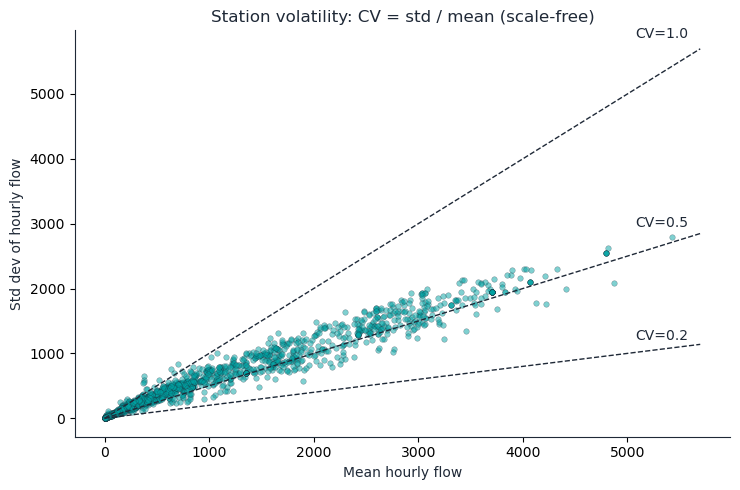

In [110]:
# ---- CV PLOTS FROM YOUR DF ----
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

def _norm(s): return re.sub(r"[^a-z0-9]", "", str(s).strip().lower())
def _find(df, names, contains=None):
    names = {_norm(n) for n in names}
    for c in df.columns:
        if _norm(c) in names: return c
    if contains:
        toks = [ _norm(contains) ] if isinstance(contains,str) else [ _norm(t) for t in contains ]
        for c in df.columns:
            if any(t in _norm(c) for t in toks): return c
    return None

# identify needed columns (robust to spacing/casing)
station_col = _find(df, ["Station","Station ID","station_id"], contains="station")
flow_col    = _find(df, ["Total Flow","total_flow"], contains=["total","flow"])
if station_col is None or flow_col is None:
    raise KeyError("Couldn't find Station/Total Flow in df.")

# A) Mean vs Std with constant-CV lines
g = df.groupby(station_col)[flow_col].agg(['mean','std']).dropna()
elec_teal, deep_navy = "#00A3A3", "#1F2937"
plt.figure(figsize=(7.5,5))
plt.scatter(g['mean'], g['std'], s=16, alpha=0.5, color=elec_teal, edgecolors=deep_navy, linewidth=0.3)
mx = g['mean'].max()*1.05
for cv in [0.2, 0.5, 1.0]:
    x = np.linspace(1e-6, mx, 200)
    plt.plot(x, cv*x, ls='--', lw=1, color=deep_navy)
    plt.text(mx*0.98, cv*mx*1.02, f"CV={cv}", ha='right', va='bottom', color=deep_navy)
plt.xlabel("Mean hourly flow", color=deep_navy); plt.ylabel("Std dev of hourly flow", color=deep_navy)
plt.title("Station volatility: CV = std / mean (scale-free)", color=deep_navy)
for s in ("top","right"): plt.gca().spines[s].set_visible(False)
plt.gca().spines["left"].set_color(deep_navy); plt.gca().spines["bottom"].set_color(deep_navy)
plt.tight_layout(); plt.savefig("cv_scatter.png", dpi=300, bbox_inches="tight")
print("Saved cv_scatter.png")

# B) Distribution of your computed CV features (choose 24h if available)
cv_cols = [c for c in df.columns if _norm(c).startswith("flow_cv_")]
cv_col = next((c for c in cv_cols if "24" in c), cv_cols[0]) if cv_cols else None
if cv_col:
    s = pd.to_numeric(df[cv_col], errors='coerce').dropna()
    plt.figure(figsize=(7.5,4))
    plt.hist(s, bins=40, color=elec_teal, edgecolor=deep_navy)
    for s_ in ("top","right"): plt.gca().spines[s_].set_visible(False)
    plt.gca().spines["left"].set_color(deep_navy); plt.gca().spines["bottom"].set_color(deep_navy)
    plt.xlabel(cv_col, color=deep_navy); plt.ylabel("Count", color=deep_navy)
    plt.title("Distribution of CV across stations/timestamps", color=deep_navy)
    plt.tight_layout(); plt.savefig("cv_distribution.png", dpi=300, bbox_inches="tight")
    print(f"Saved cv_distribution.png using {cv_col}")


Saved cv_scatter_by_cv_clean_labeled.png


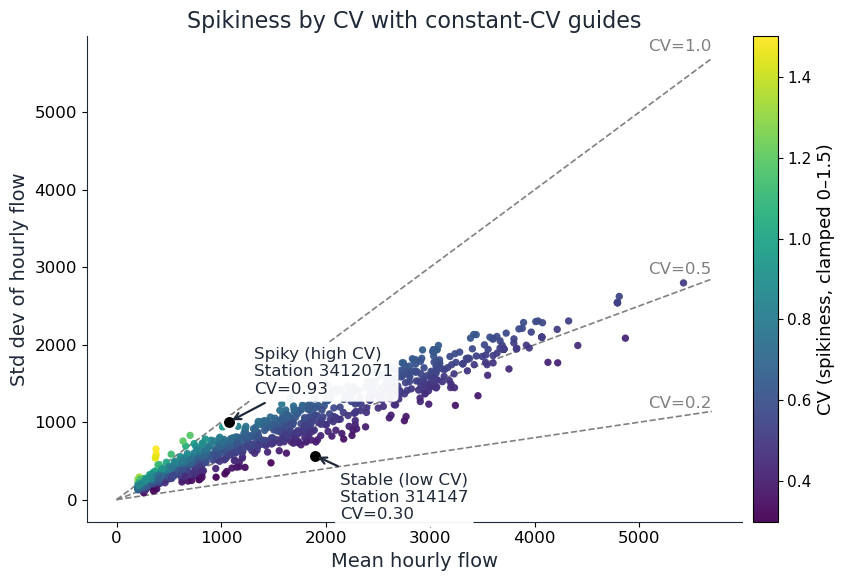

In [114]:
# Make the CV scatter legible: bigger fonts, annotation boxes, high DPI
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---- pick columns from your df ----
station_col = next(c for c in df.columns if c.lower().startswith('station'))
flow_col    = next(c for c in df.columns if ('total' in c.lower()) and ('flow' in c.lower()))

# ---- station-level summary ----
g = df.groupby(station_col)[flow_col].agg(['mean','std']).dropna()
g['CV'] = g['std'] / g['mean']
g = g[g['mean'] >= 200].copy()            # drop tiny-mean stations (explodes CV)
g['CV_clip'] = g['CV'].clip(0.0, 1.5)     # clamp for color scale

# exemplar stations
busy = g[g['mean'] > g['mean'].median()]
lo_id = busy['CV'].idxmin()
hi_id = busy['CV'].idxmax()

# ---- styling ----
elec_teal = "#00A3A3"; deep_navy = "#1F2937"

plt.rcParams.update({
    "font.size": 13,       # base
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

fig, ax = plt.subplots(figsize=(9,6))
sc = ax.scatter(g['mean'], g['std'], c=g['CV_clip'], s=28, cmap='viridis',
                alpha=0.95, edgecolors='none', zorder=2)

# constant-CV guide lines
mx = g['mean'].max()*1.05
x = np.linspace(1e-6, mx, 200)
for cv, yoff in [(0.2,1.01),(0.5,1.01),(1.0,1.01)]:
    ax.plot(x, cv*x, ls='--', lw=1.2, color='gray', zorder=1)
    ax.text(mx, cv*mx*yoff, f"CV={cv}", ha='right', va='bottom', color='gray', fontsize=12)

# annotate exemplars with readable white boxes
def annotate_station(sid, label, xytext):
    m, s = g.loc[sid, ['mean','std']]
    ax.scatter([m],[s], s=90, color='black', edgecolors='white', linewidth=1.6, zorder=4)
    ax.annotate(f"{label}\nStation {sid}\nCV={g.loc[sid,'CV']:.2f}",
                xy=(m,s), xytext=xytext, textcoords='offset points',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='none', alpha=0.95),
                arrowprops=dict(arrowstyle='->', color=deep_navy, lw=1.6),
                color=deep_navy, fontsize=12, zorder=5)

annotate_station(lo_id, "Stable (low CV)", (18,-48))   # tweak offsets if needed
annotate_station(hi_id, "Spiky (high CV)", (18, 18))

# axes + colorbar
cbar = fig.colorbar(sc, ax=ax, pad=0.015)
cbar.set_label("CV (spikiness, clamped 0–1.5)", fontsize=13)
cbar.ax.tick_params(labelsize=11)

ax.set_xlabel("Mean hourly flow", color=deep_navy)
ax.set_ylabel("Std dev of hourly flow", color=deep_navy)
ax.set_title("Spikiness by CV with constant-CV guides", color=deep_navy)

for s in ("top","right"): ax.spines[s].set_visible(False)
ax.spines["left"].set_color(deep_navy); ax.spines["bottom"].set_color(deep_navy)

fig.tight_layout()
fig.savefig("cv_scatter_by_cv_clean_labeled.png", dpi=450, bbox_inches="tight")
print("Saved cv_scatter_by_cv_clean_labeled.png")


## Basic Graphical Exploration

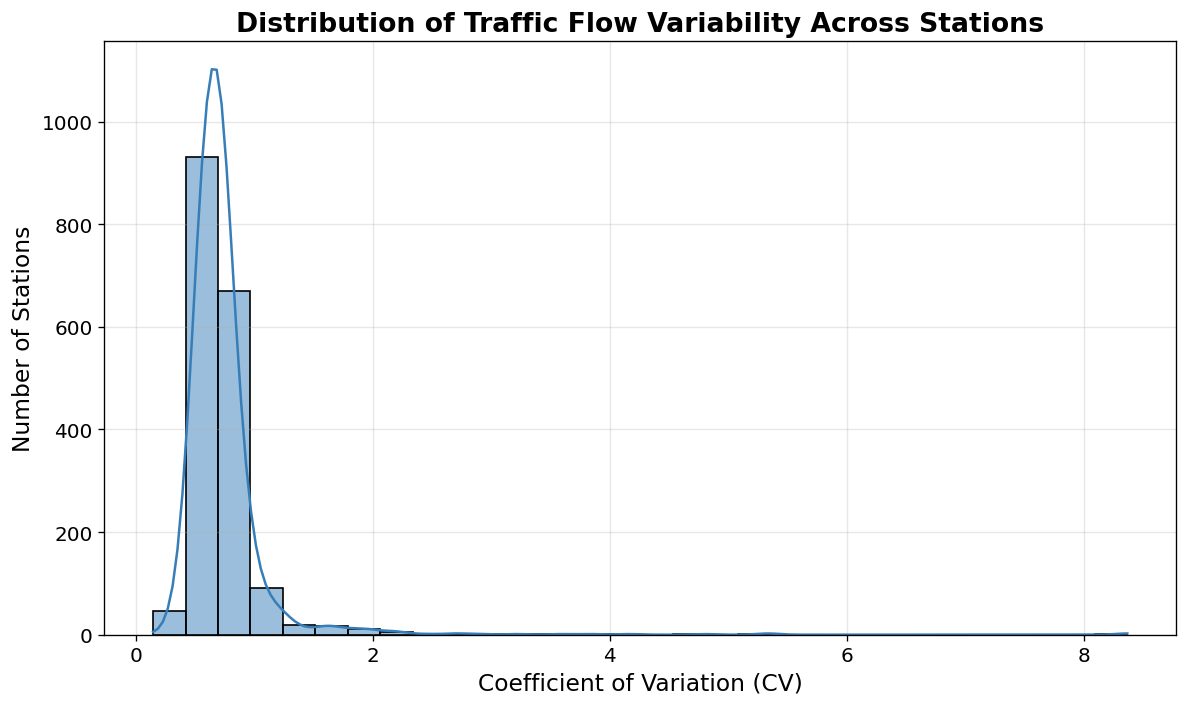

In [37]:
plt.figure(figsize=(10, 6), dpi=120)
sns.histplot(station_stats['CV'], bins=30, kde=True, color="#377eb8", edgecolor="black")

plt.title('Distribution of Traffic Flow Variability Across Stations', fontsize=16, fontweight='bold')
plt.xlabel('Coefficient of Variation (CV)', fontsize=14)
plt.ylabel('Number of Stations', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

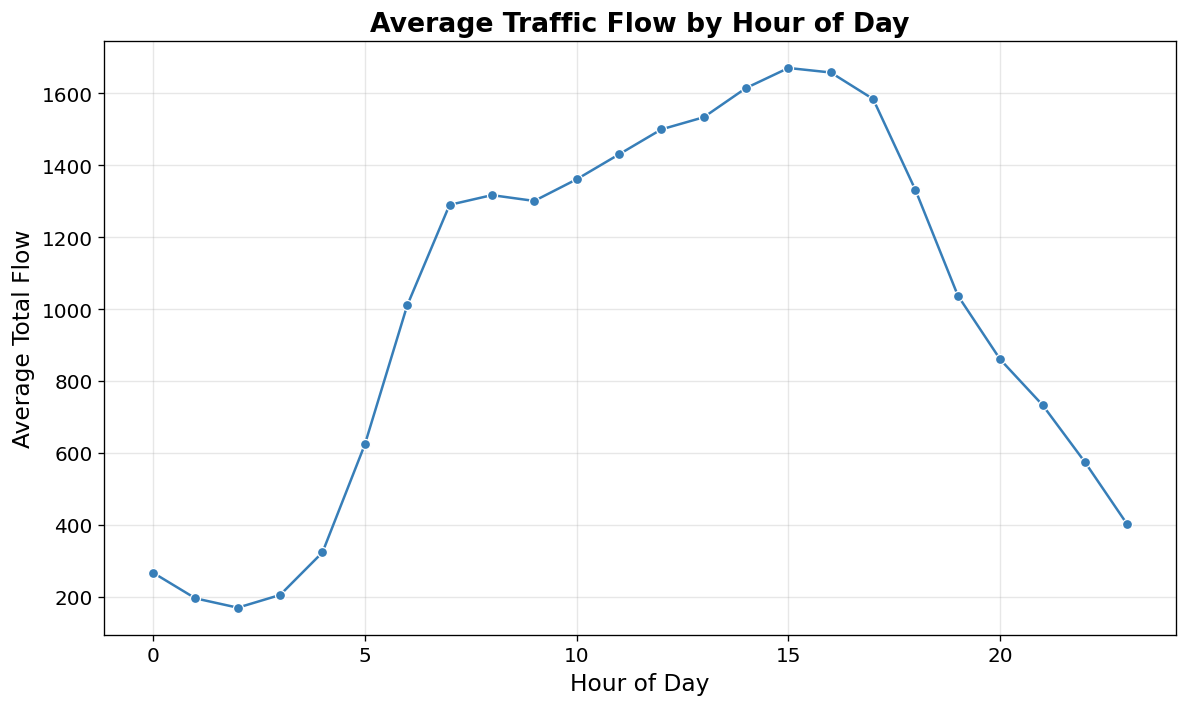

In [38]:
hourly_flow = df.groupby('Hour')['Total Flow'].mean().reset_index()

plt.figure(figsize=(10, 6), dpi=120)
sns.lineplot(data=hourly_flow, x='Hour', y='Total Flow', marker='o', color='#377eb8')

plt.title('Average Traffic Flow by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Average Total Flow', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

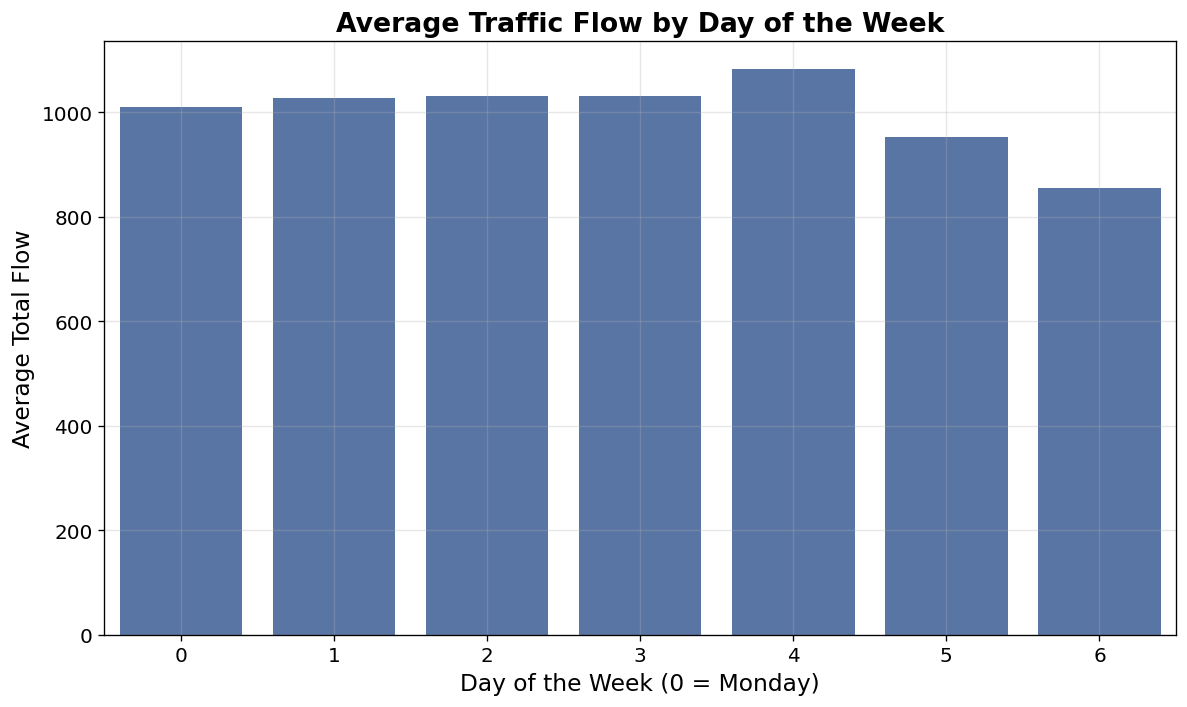

In [39]:
weekday_flow = df.groupby('Weekday')['Total Flow'].mean().reset_index()

# Weekday traffic plot with consistent color and no warning
plt.figure(figsize=(10, 6), dpi=120)
sns.barplot(data=weekday_flow, x='Weekday', y='Total Flow', color="#4c72b0")  # professional muted blue

plt.title('Average Traffic Flow by Day of the Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week (0 = Monday)', fontsize=14)
plt.ylabel('Average Total Flow', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
df['IsHoliday'] = df['IsHoliday'].astype('category')
df['Route'] = df['Route'].astype('category')

In [37]:
#  Keep only numeric features
numeric_df = df.select_dtypes(include='number')

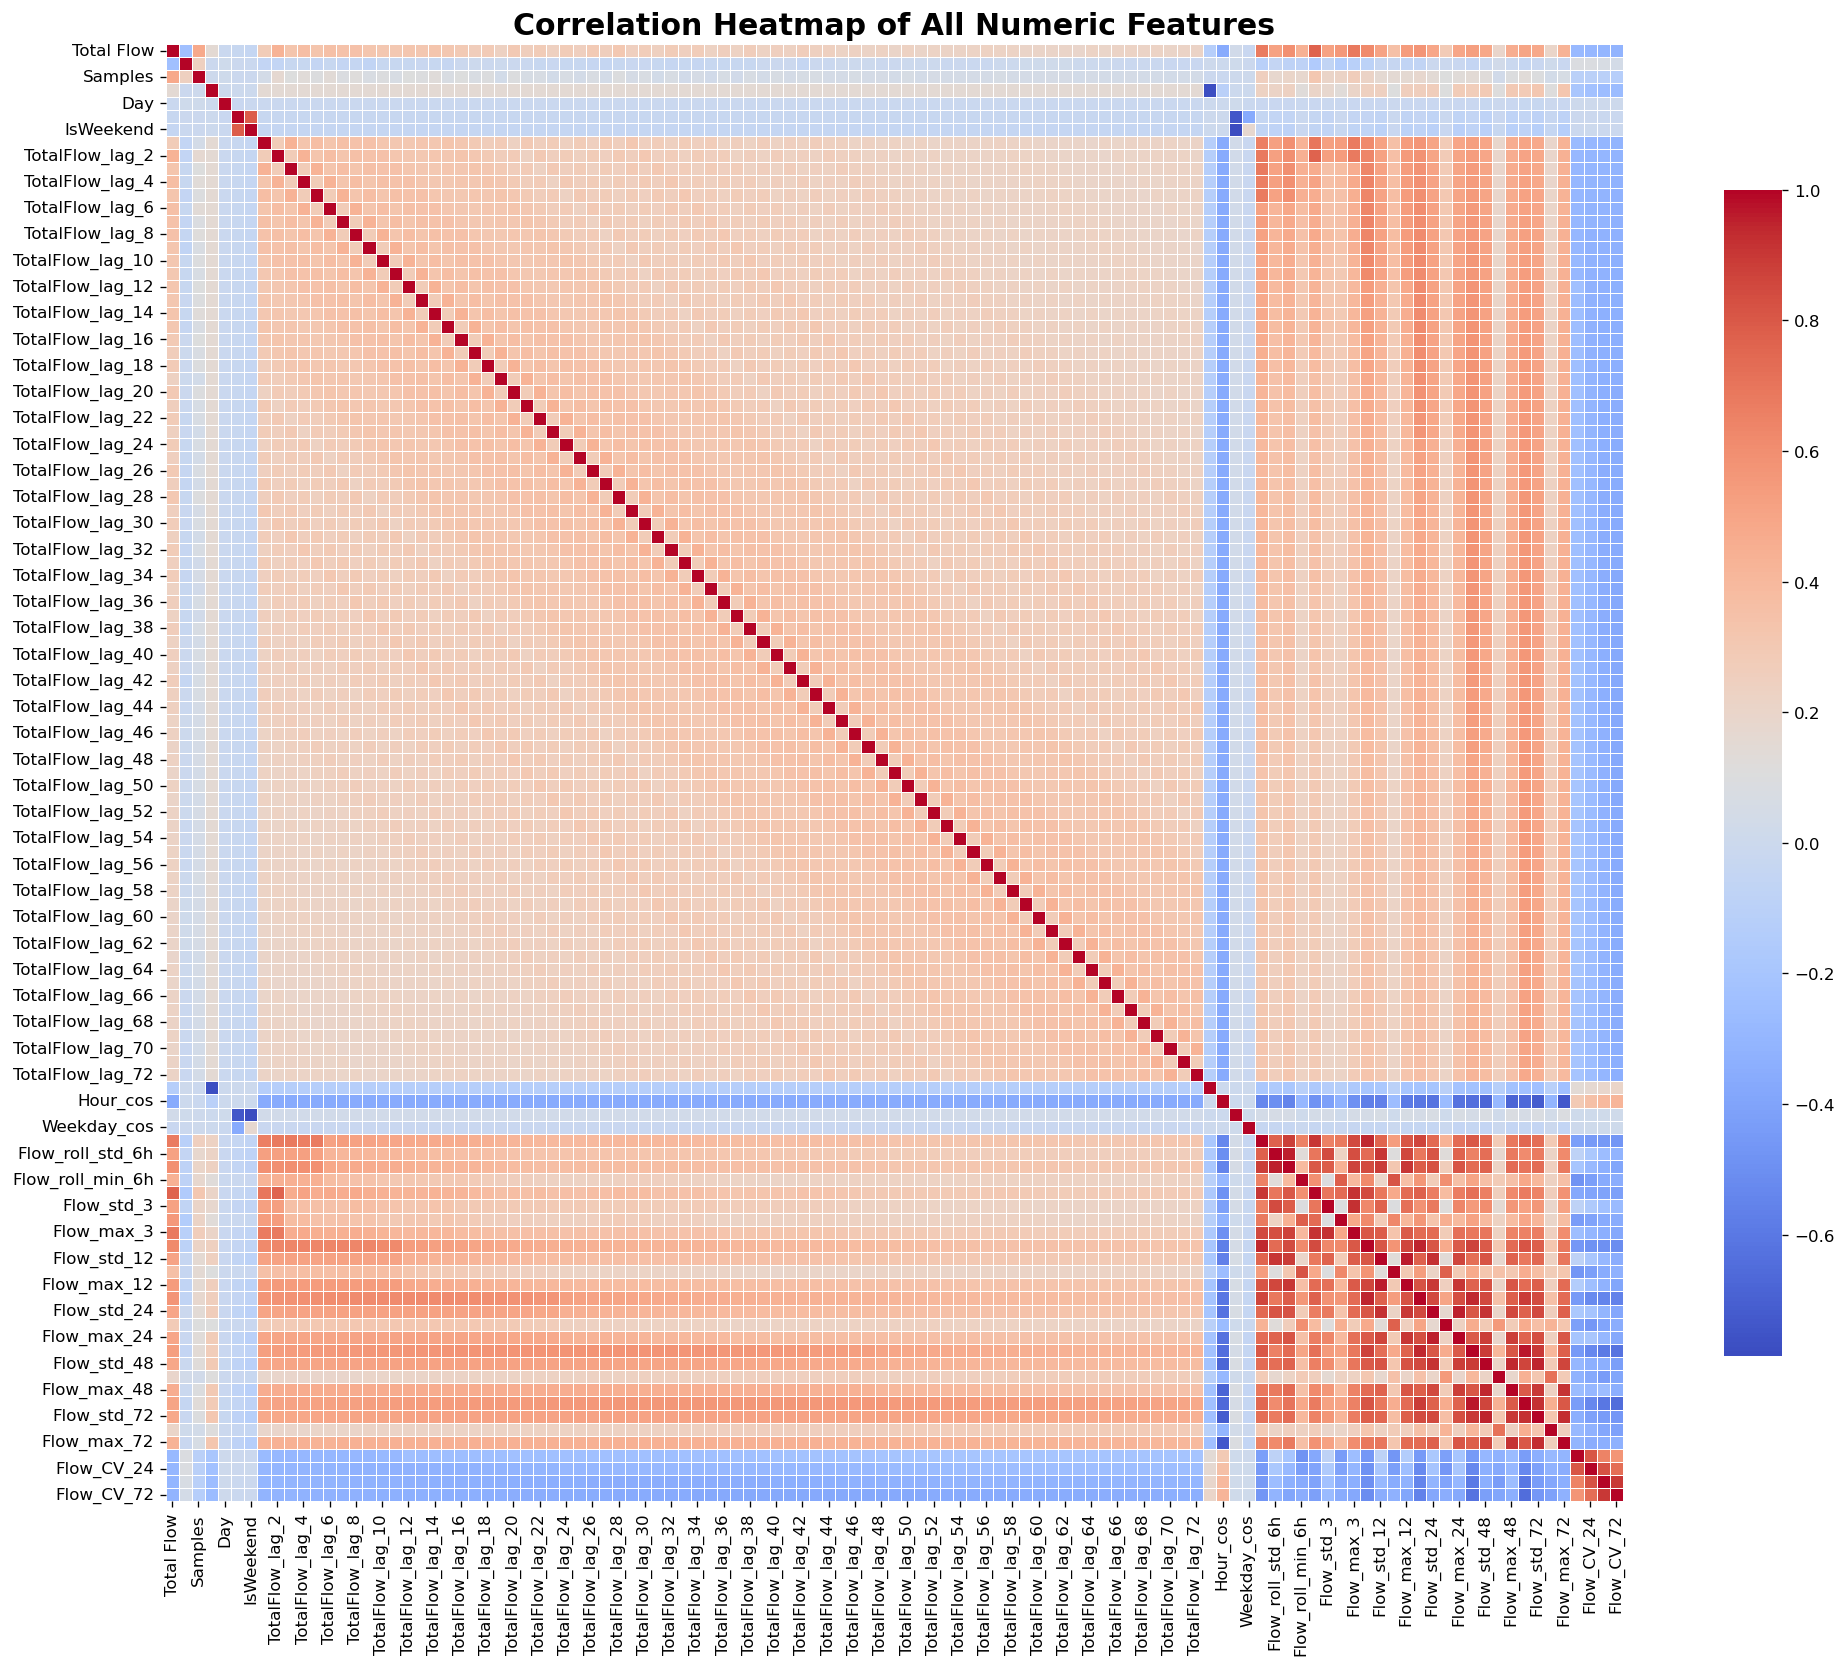

In [39]:
# Plot full correlation matrix
plt.figure(figsize=(18, 14), dpi=120)
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f",
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Heatmap of All Numeric Features", fontsize=18, fontweight='bold')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

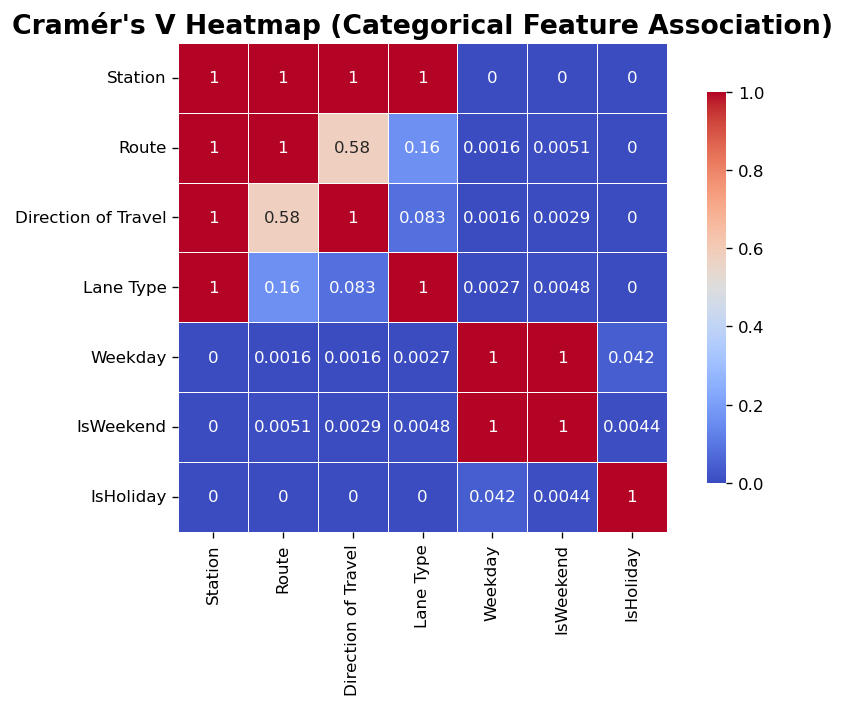

In [41]:
# Function to compute Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# List of your categorical variables
cat_vars = ['Station', 'Route', 'Direction of Travel', 'Lane Type', 'Weekday', "IsWeekend", "IsHoliday"]

# Create empty matrix
cramers_results = pd.DataFrame(index=cat_vars, columns=cat_vars)

# Compute Cramér’s V for each pair
for col1 in cat_vars:
    for col2 in cat_vars:
        cramers_results.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Convert to numeric matrix
cramers_results = cramers_results.astype(float)

# Plot heatmap
plt.figure(figsize=(8, 6), dpi=120)
sns.heatmap(cramers_results, annot=True, cmap='coolwarm', vmin=0, vmax=1, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Cramér's V Heatmap (Categorical Feature Association)", fontsize=16, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [38]:
cat_features = [
    'Station', 'Route', 'Direction of Travel', 'Lane Type',
    'Weekday', 'IsWeekend', 'IsHoliday'
]

for col in cat_features:
    df[col] = df[col].astype('category')

In [39]:
# Define target and features
target = 'Total Flow'
features = [col for col in df.columns if col != target]

In [40]:
# Split the data
X = df[features]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define datasets
train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
val_set = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=train_set)

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

# Train with callback for early stopping
model = lgb.train(
    params,
    train_set,
    num_boost_round=100,
    valid_sets=[train_set, val_set],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 105.061	valid_1's rmse: 106.529


Saved feature_importance_top5_gain.png


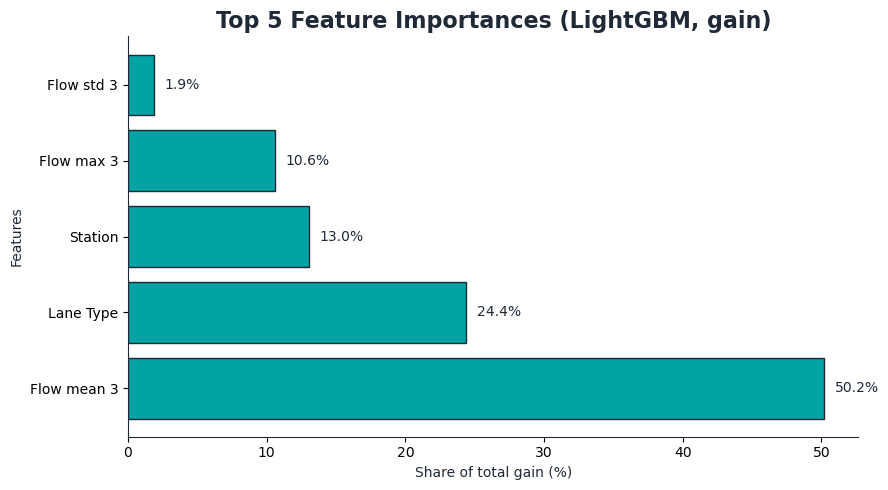

In [43]:
# Polished Top-5 LightGBM gain importances (normalized to %)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, textwrap

N = 5
ELEC_TEAL, DEEP_NAVY = "#00A3A3", "#1F2937"

# 1) Get gain importances from your trained LightGBM model
booster = model.booster_ if hasattr(model, "booster_") else model  # works for LGBMRegressor
gain = booster.feature_importance(importance_type="gain")
names = booster.feature_name()
imp = pd.Series(gain, index=names)

# 2) Keep top-N and normalize to percent
imp = imp[imp > 0].sort_values(ascending=False).head(N)
imp_pct = (imp / imp.sum() * 100)

# 3) Prettify feature names for the slide
def nice(name: str) -> str:
    name = name.replace("Flow_", "Flow ")
    name = name.replace("_", " ")
    name = name.replace("lag ", "lag ")
    name = name.replace("Hour_cos", "Hour cos")
    name = name.replace("Hour_sin", "Hour sin")
    name = name.replace("% Observed", "Percent Observed")
    return name
labels = [nice(c) for c in imp_pct.index]

# 4) Plot
plt.figure(figsize=(9, 5))
bars = plt.barh(labels, imp_pct.values, color=ELEC_TEAL, edgecolor=DEEP_NAVY)
for b, v in zip(bars, imp_pct.values):
    plt.text(v + 0.8, b.get_y() + b.get_height()/2, f"{v:.1f}%", va="center", color=DEEP_NAVY)

plt.xlabel("Share of total gain (%)", color=DEEP_NAVY)
plt.ylabel("Features", color=DEEP_NAVY)
plt.title("Top 5 Feature Importances (LightGBM, gain)", color=DEEP_NAVY, fontsize=16, fontweight="bold")

for s in ("top", "right"): plt.gca().spines[s].set_visible(False)
plt.gca().spines["left"].set_color(DEEP_NAVY); plt.gca().spines["bottom"].set_color(DEEP_NAVY)
plt.tight_layout()
plt.savefig("feature_importance_top5_gain.png", dpi=300, bbox_inches="tight")
print("Saved feature_importance_top5_gain.png")


In [43]:
# Final feature groups
flow_features = [
    'Flow_mean_3', 'Flow_std_3', 'Flow_max_3', 'Flow_min_3',
    'Flow_mean_72', 'Flow_std_72', 'Flow_std_48', 'Flow_max_24',
    'Flow_mean_24', 'Flow_mean_48',
    'Flow_roll_std_6h', 'Flow_roll_max_6h',
    'Flow_CV_48'
]

lag_features = [
    'TotalFlow_lag_1', 'TotalFlow_lag_2', 'TotalFlow_lag_3',
    'TotalFlow_lag_7', 'TotalFlow_lag_8',
    'TotalFlow_lag_15', 'TotalFlow_lag_18'
]

time_features = [
    'Hour', 'Hour_cos', 'Hour_sin', 'Weekday_cos'
]

quality_features = [
    'Samples', '% Observed'
]

# Copy original DataFrame
df_model = df.copy()

# One-hot encode low-cardinality features
df_model = pd.get_dummies(df_model, columns=['IsHoliday', 'Direction of Travel'], drop_first=True)

# Label encode high-cardinality categorical features
for col in ['Station', 'Route', 'Lane Type']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Capture dummy columns dynamically
dummy_columns = [col for col in df_model.columns if col.startswith('IsHoliday_') or col.startswith('Direction of Travel_')]

# Final feature list
categorical_features = ['Lane Type', 'Route', 'Station']
selected_features = flow_features + lag_features + time_features + quality_features + categorical_features + dummy_columns


In [44]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

def evaluate_baseline_linear_model(df, selected_features, forecast_horizons=[12, 24, 48, 72]):
    results = []

    for horizon in forecast_horizons:
        target = f'TotalFlow_lag_{horizon}'
        df_model = df.dropna(subset=[target] + selected_features)

        X = df_model[selected_features]
        y = df_model[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        results.append({
            'Horizon': f'{horizon} hours',
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE (%)': round(mape, 2)
        })

    return pd.DataFrame(results)

In [45]:
baseline_results = evaluate_baseline_linear_model(df_model, selected_features)
print("Linear Regression Baseline Results:")
print(baseline_results)

Linear Regression Baseline Results:
    Horizon     MAE     RMSE  MAPE (%)
0  12 hours  696.04  1027.22    904.75
1  24 hours  724.70  1062.04    977.09
2  48 hours  732.64  1069.39   1033.49
3  72 hours  778.93  1120.21   1162.42


In [48]:
# Save Random Forest results to CSV on your NoMachine machine
baseline_results.to_csv('baseline_results.csv', index=False)

print(" Results saved as 'baseline_results.csv' in your working directory.")

 Results saved as 'baseline_results.csv' in your working directory.


# Results

####  The Random Forest and LSTM models were trained in a separate notebook to improve runtime efficiency. 
#### Their results are summarized below for comparison.


##  Model Comparison for Traffic Flow Forecasting

This table summarizes the performance of three models—**Random Forest**, **Linear Regression**, and **LSTM**—on the traffic flow prediction task at different forecast horizons.

###  Random Forest Model Results

| Horizon  | MAE    | RMSE   | MAPE (%) |
| -------- | ------ | ------ | -------- |
| 12 hours | 586.70 | 866.81 | 827.08   |
| 24 hours | 627.20 | 925.22 | 913.56   |
| 48 hours | 649.33 | 955.91 | 945.54   |
| 72 hours | 685.43 | 996.50 | 1028.74  |


###  Linear Regression Baseline Results

| Horizon  | MAE    | RMSE    | MAPE (%) |
| -------- | ------ | ------- | -------- |
| 12 hours | 696.04 | 1027.22 | 904.75   |
| 24 hours | 724.70 | 1062.04 | 977.09   |
| 48 hours | 732.64 | 1069.39 | 1033.49  |
| 72 hours | 778.93 | 1120.21 | 1162.42  |


### LSTM Model Result

| Horizon   | MAE     | RMSE     | MAPE (%)      |
|-----------|---------|----------|---------------|
| 12 hours  | 245.16  | 388.32   | 1.10e+16      |
| 24 hours  | 361.16  | 574.77   | 1.69e+16      |
| 48 hours  | 421.01  | 671.78   | 2.31e+16      |
| 72 hours  |         |          |               |




While evaluating the LSTM model, we observed unusually large MAPE values across all forecast horizons. This discrepancy is due to the sensitivity of MAPE to near-zero actual values in the denominator, which can inflate error scores even when the absolute prediction error is small.

Given the nature of traffic data, some actual flow values are close to zero. This results in mathematically valid but practically misleading MAPE values.

In contrast, MAE and RMSE provide more reliable and interpretable performance indicators. As seen in the table, the LSTM model achieves the lowest MAE and RMSE across all horizons—indicating strong predictive performance despite MAPE distortion.